# Altair

### Handy hints 

Some Jupyter shortcut keys:

- Esc : get into Command mode (leaves Edit mode)
- Enter : edit a cell (puts you in Edit mode)
- h : see help (see all commands)
- Shift+Enter or Ctrl+Enter : run the code in the cell
- a / b : add new cell above/below
- m : turn current cell into a Markdown cell
- y : turn current cell into a Code cell
- 1-6 : turn current cell into a heading (a type of Markdown cell)

You can get help on Python objects and functions with `help()` or the `?` operator.

In general, we are using plotting libraries that return objects encapsulating the plot. You can check the type of these returned objects with `type()`. 

Some of the plotting libraries we use need to communicate a lot of data to the browser. Current versions of Jupyter shouldn't have a problem, but if you are running an older version, you may need to launch this notebook with a higher data rate limit: `jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000`

## Setup 

Altair is not bundled with Anaconda - you may need

`conda install -c conda-forge altair vega`

In [26]:
import pandas as pd
import numpy as np

In [27]:
# We may want to use some colours etc from other libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# import and initialise altair
import altair as alt
# this line is needed in jupyter notebook, but not jupyter-lab
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Data 

For this workshop we're going to load in two main datasets:

### LTEE data 

This data is from the [Long Term Evolution Experiment (LTEE)](http://myxo.css.msu.edu/ecoli/). This experiment has been running for over 30 years and over 50,000 E. coli generations, and is still ongoing. Twelve separate populations of E. coli have been propagated for the life of the experiment. Every 500 generations, each population is cloned and stored, allowing researchers to study evolutionary behaviour over the long term, and to "rewind and replay" alternate evolutionary trajectories by propagating from an earlier clone. 

Several interesting events have occurred during the experiment. Some populations have spontaneously developed hypermutator phenotypes. In addition, around generation 31,000 one population, Ara-3, spontaneously developed a rare and novel Cit+ mutation, giving it the ability to metabolise citrate in the substrate.

There have been many publications from this experiment. A handful:

- [Blount et al 2008: Historical contingency and the evolution of a key innovation in an experimental population of Escherichia coli](https://www.pnas.org/content/105/23/7899) - on the spontaneous development of citrate metabolisation and on potentiating mutations
- [Tenaillon et al 2016: Tempo and mode of genome evolution in a 50,000-generation experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4988878) - various investigations by sequencing and variant-calling over 50,000 generations of clones, including discussion of hypermutator phenotypes and genetic drift vs natural selection.

Sequence data from clones is available, but for this workshop we'll just be using some published tabular data.

A version of this dataset is also used by the [Data Carpentry lessons on Genomics](https://datacarpentry.org/genomics-workshop/).

In this lesson we'll use a large flat file containing both sample metadata on each clone, and information on observed mutations in their genomes.

In [29]:
# If you have done the pandas and data tidying workshop and saved the final file,
# you can try reading that file in here if you prefer
ltee = pd.read_csv('ltee_merged.csv',
                   index_col = 'Strain ID')

### House sales data 

This data represents house sales in Seattle in 2014 and 2015. We have information on the houses themselves: location, size, quality, view, and whether the house is tagged as 'waterfront' or not. We also have information on the date and price of each sale.

In [ ]:
sales = pd.read_csv("housing-data-10000.csv", 
                    usecols=['id','date','price','lat','long', 'zipcode',
                             'waterfront','view','grade','sqft_living'],
                    parse_dates=['date'], 
                    dtype={'zipcode': 'category',
                           'waterfront': 'bool'})

# We'll downsample in order to make plots a bit simpler and smaller to store
# In particular Altair defaults to a limit of 5000 observations
sales = sales.sample(3000)

### Demo data 

We'll read in the classic `iris` and `mtcars` datasets for demo purposes.

In [ ]:
iris = pd.read_csv('iris.csv')
cars = pd.read_csv('mtcars.csv')

## Altair 

[Altair](https://altair-viz.github.io) is a library for creating interactive plots. 

Altair is built around the [Vega-Lite](https://vega.github.io/vega-lite/) schema, a "visualisation grammar". Altair plots are specified in Python, then converted behind the scenes to a declarative JSON structure that follows the Vega-Lite schema, which can then be rendered by a Javascript library.

Altair works very well with Pandas - in fact, it usually expects data to be in a Pandas DataFrame.

### Simple interactive plotting

Here's a simple example of an Altair plot.

In [ ]:
df = pd.DataFrame({
    'Time': [1,2,3,4,5],
    'Projected': [2,5,10,17,26],
    'Actual': [1,4,9,11,9]
})

chart = alt.Chart(df)

chart.mark_line(color='blue').encode(x='Time', y='Projected')

Here `mark_line()` tells Altair we want to draw a line, and `encode()` is used to assign our variables (columns of the DataFrame) to possible encoding channels of the line. We've just used `x` and `y`. Notice that we set the colour in `mark_line()`; if we'd wanted to set the colour to encode some variable, we would have set it in `encode()`.

Simple pan-and-zoom interactivity can be added with `.interactive()`:

In [ ]:
chart = alt.Chart(df)

chart.mark_line(color='blue').encode(x='Time', y='Projected').interactive()

If we wanted to produce the chart we produced earlier, with scatter points, we can use `alt.layer()`, which takes the components as arguments, or just the `+` operator: 

In [ ]:
df = pd.DataFrame({
    'Time': [1,2,3,4,5],
    'Projected': [2,5,10,17,26],
    'Actual': [1,4,9,11,9],
})

chart = alt.Chart(df)
line = chart.mark_line(color='blue').encode(x='Time', y='Projected')
points = chart.mark_point(color='red').encode(x='Time',y='Actual')

# or alt.layer(line, points).interactive()
(line + points).interactive()

#### Exercise: 

Recreate, in Altair, the scatter plot of house sales with x-coordinates given by `longitude` and y-coordinates given by `latitude`. You can use `.mark_point()` or `.mark_circle()`. One issue you will discover, if you use the `x` and `y` encodings, is that Altair and Vega-lite include the axis zero by default. 

## Data types 

Altair recognises four fundamental [data types](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types):

| Data Type | Shorthand Code | Description |
|-|-|-|
| quantitative | Q | a continuous real-valued quantity |
| ordinal | O | a discrete ordered quantity |
| nominal | N | a discrete unordered category |
| temporal | T | a time or date value |

In [ ]:
alt.Chart(sales.sample(10))\
    .mark_bar()\
    .encode(x='date:N', y='price:Q')

In [ ]:
# What kind of sequencing experiments have been done on the LTEE data?

chart = alt.Chart(data=ltee)

chart.mark_point().encode(
    x=alt.X('Sequencing Depth'), #, scale=alt.Scale(type='log')), 
    y='Read Type',
    color='Read Length:Q'
)

#### Exercise:

* Colour your "geographical" scatter plot of house sales according to whether the property is or is not a waterfront property. What is the appropriate data type?
* Colour according to price (if you prefer, try a log scale). What is the appropriate data type?
* Colour according to view. What is the appropriate data type?

## Marks and encodings 

Altair has various marks used to draw different kinds of plots. For instance:

* `mark_point()` : points on a scatter plot
* `mark_bar()` : rectangular bars, in e.g. a bar plot or histogram
* `mark_area()` : filled/shaded areas

The full list of marks can be found at [https://altair-viz.github.io/user_guide/marks.html](https://altair-viz.github.io/user_guide/marks.html).

We can assign variables of the DataFrame to different encoding channels. For instance:

* `x` and `y` : position of mark (scatterpoint position, top of bar-chart bar, etc)
* `color` : colour of the mark (colour of point, bar, shaded area etc)
* `size` : size of the mark (point size, bar width, etc)

You can find a list of encodings at [https://altair-viz.github.io/user_guide/encoding.html](https://altair-viz.github.io/user_guide/encoding.html).

In [ ]:
# Demo: marks from common base
base = alt.Chart(sales.sample(10)).encode(x='date:T', y='price:Q') 

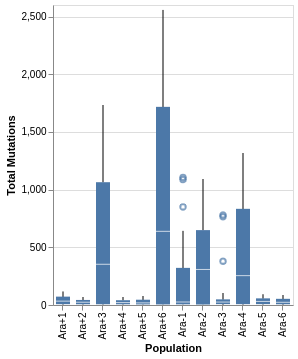

In [30]:
# Demo: box plot
base = alt.Chart(ltee)

base.mark_boxplot().encode(x='Population', 
                           y='Total Mutations')
# Log scale works here
# Color also works here (sort of!)

## Aggregations 

Many common plot types involve summarising the data:

* histograms involve putting some continuous variable into bins (_binning_), and then _counting_ how many samples are in each bin
* bar charts or point plots usually involve plotting the _mean_ of some variable, and possibly error bars based on _confidence intervals_
* box plots usually involve finding the _mean_, _quartiles_, _min_ and _max_ of some variable (although as of v3 Altair has a built-in boxplot mark type).

Combining aggregation functions with different kind of marks is very powerful. 

Most aggregations have a shorthand string form (e.g. encode `y='count()'`) and a longer form (e.g encode `y=alt.Y(aggregate='count', type='quantitative')`).

Binning is done using an explicit axis object like `alt.X()` or `alt.Y()`, with `bin=True` or `bin=alt.Bin()`.

You can find a list of aggregation functions at [https://altair-viz.github.io/user_guide/encoding.html#binning-and-aggregation](https://altair-viz.github.io/user_guide/encoding.html#binning-and-aggregation)

In [ ]:
# Demo: Histogram of iris petal lengths

In [ ]:
# Demo: LTEE heatmap

#### Exercise:
1. Using `mark_bar()`, create a histogram of total mutation counts from the `ltee` data.
2. Try the same plot but using `.mark_area()`.
3. On the original histogram, try setting the `color` encoding to the `Mutator` field. Do you get a stacked or layered histogram by default? (This can be controlled using the `stack` parameter to `alt.Y()`).

In [ ]:
#ltee
chart = alt.Chart(ltee)

chart.mark_area(opacity=0.3).encode(
    alt.X('Total Mutations', 
          bin=alt.Bin(maxbins=20)),
    alt.Y('count()', stack=None))

## Interactivity 

Hover text can be added to a plot simply by setting the `tooltip` encoding.

#### Exercise: 

On your scatter plot of house location, set the hover info to display the sale price.

Basic pan-and-zoom interactivity is set with `.interactive()`. This is actually short for:

```
chart.add_selection(
    alt.selection_interval(bind='scales')
)
```

This means we've added a behaviour where dragging the mouse (selecting an interval) causes the plot to zoom and pan (bind='scales'). We can create custom interactive behaviour with [bindings, selections, and conditions](https://altair-viz.github.io/user_guide/interactions.html).


We can define particular kinds of selections with Altair functions:

* `selection_interval()` allows us to select everything in a region of the plot by dragging over it
* `selection_single()` allows us to select a single element by clicking on it
* `selection_multi()` allows us to select multiple elements by holding shift and clicking

`add_selection()` is used to the defined selection object to a plot.

`alt.condition()` is used to change plot encodings conditional on whether an element is currently selected or not. This is what makes the plots interactive.

#### Exercise:

You're given the below plot, where we've added a selection that changes the colour of the points in `area_price_chart` when selected. Edit the `location_chart` so that when points are selected in `area_price_chart`, they are _also_ highlighted in `location_chart`.

In [ ]:
selected_houses = alt.selection_interval()

area_price_chart = alt.Chart(data=sales)\
    .mark_circle(size=20, opacity=0.5)\
    .encode(
        x='sqft_living:Q',
        y=alt.Y('price:Q', scale=alt.Scale(type='log')),
        color=alt.condition(selected_houses,
                            alt.value('red'),
                            alt.value('lightgrey')))\
    .add_selection(selected_houses)

location_chart = alt.Chart(data=sales)\
    .mark_circle(size=20)\
    .encode(
        alt.X('long', scale=alt.Scale(zero=False)),
        alt.Y('lat', scale=alt.Scale(zero=False))
        )

area_price_chart | location_chart